In [1]:
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
import torch.optim as optim
from probe_experiment import ProbeExperiment

In [2]:
with open('data/filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)
annotations.sort(key = lambda ant : ant['f_name'])

train_ants = annotations[:int(len(annotations)*0.8)]
test_ants = annotations[int(len(annotations)*0.8):]

keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye']

### Go Model

In [3]:
from go_model import GoModel
go_model = GoModel(None)
checkpoint = torch.load('model_ckpt.pth.tar', map_location=torch.device('cuda'))
state_dict = checkpoint['state_dict']
state_dict = {key[7:]:state_dict[key] for key in state_dict} #remove 'module.' prefix
go_model.load_state_dict(state_dict)

class GoFeatModel(nn.Module):
    
    def __init__(self, go_model):
        super(GoFeatModel, self).__init__()
        self.convs = go_model.convs
        self.nonlinear = go_model.nonlinear
    
    def forward(self, x):
        for i in range(len(self.convs)):
            x = self.convs[i](x)
            x = self.nonlinear(x)
        return nn.Flatten()(x)
    
feat_model = GoFeatModel(go_model)
feat_model = feat_model.cuda() 

### Probe Model

In [4]:
hidden_dim = 512
mlp_probe = nn.Sequential(
    nn.Linear(11552, hidden_dim),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.Linear(hidden_dim, len(keywords))).cuda()
probe_model = mlp_probe

### Training

In [5]:
exp = ProbeExperiment(train_ants, test_ants, keywords)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(probe_model.parameters())
exp.run('mlp_probe', feat_model, probe_model, criterion, optimizer, batch_size=64, num_epochs=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [01:25<00:00,  8.52it/s]


epoch 0 loss 0.157775
new best ckpt


  0%|                                                                                                                            | 0/2926 [00:00<?, ?it/s]

epoch 1 loss 0.158860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [01:24<00:00,  8.62it/s]


epoch 2 loss 0.159958


 41%|██████████████████████████████████████████████▌                                                                  | 1205/2926 [02:32<03:38,  7.88it/s]


KeyboardInterrupt: 

### Probe Evaluation

In [6]:
preds, labels = exp.test_inference(feat_model, probe_model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [01:55<00:00,  6.33it/s]


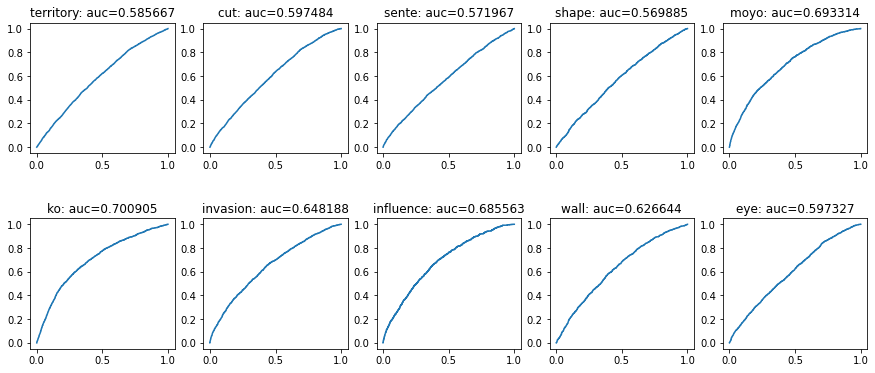

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from math import ceil

cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_preds, kw_labels = preds[:,kw], labels[:,kw]
    fprs, tprs, _ = roc_curve(kw_labels, kw_preds)
    auc = roc_auc_score(kw_labels, kw_preds)
    axs[kw//cols][kw%cols].plot(fprs, tprs)
    axs[kw//cols][kw%cols].set_title('%s: auc=%f' % (keywords[kw], auc))